Species distribution across both datasets:
species_name
Harmonia axyridis           17706
Apis mellifera              17123
Bombus griseocollis          5873
Popillia japonica            5708
Lymantria dispar             5653
Halyomorpha halys            3192
Tenodera sinensis            2033
Chinavia hilaris             1573
Cicindela sexguttata         1478
Vespula maculifrons          1377
Adelges tsugae               1313
Graphocephala coccinea       1200
Vespula germanica             943
Coleomegilla maculata         887
Cotinis nitida                858
Lycorma delicatula            853
Jikradia olitoria             536
Stagmomantis carolina         334
Agrilus planipennis           207
Anoplophora glabripennis        1
Name: count, dtype: int64

Total images: 68848
Unique species: 20


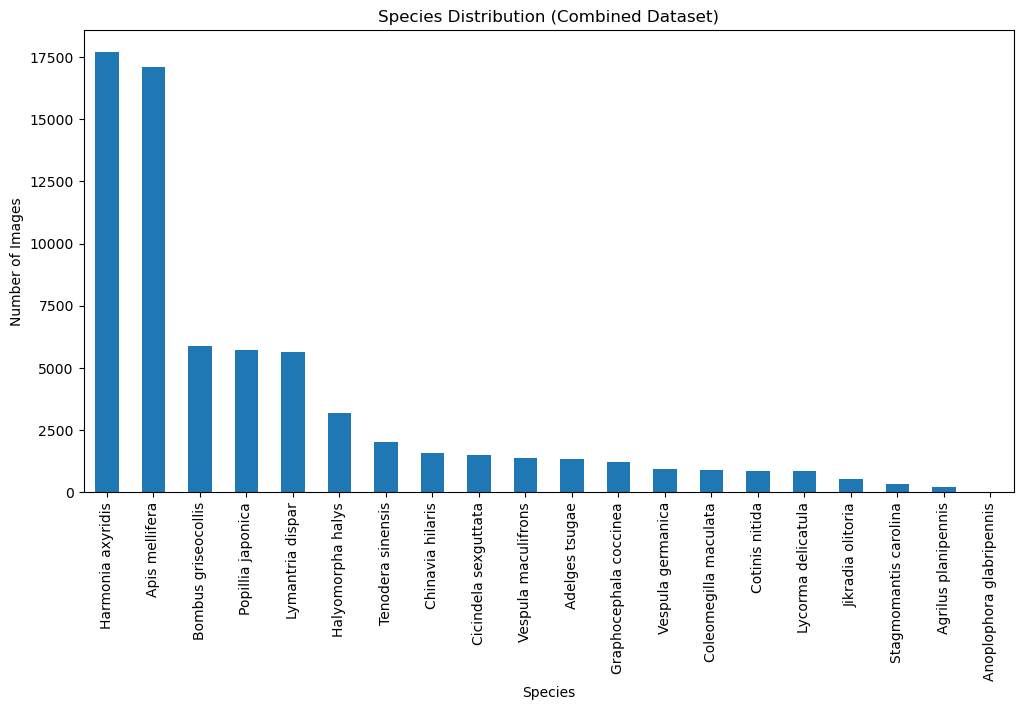

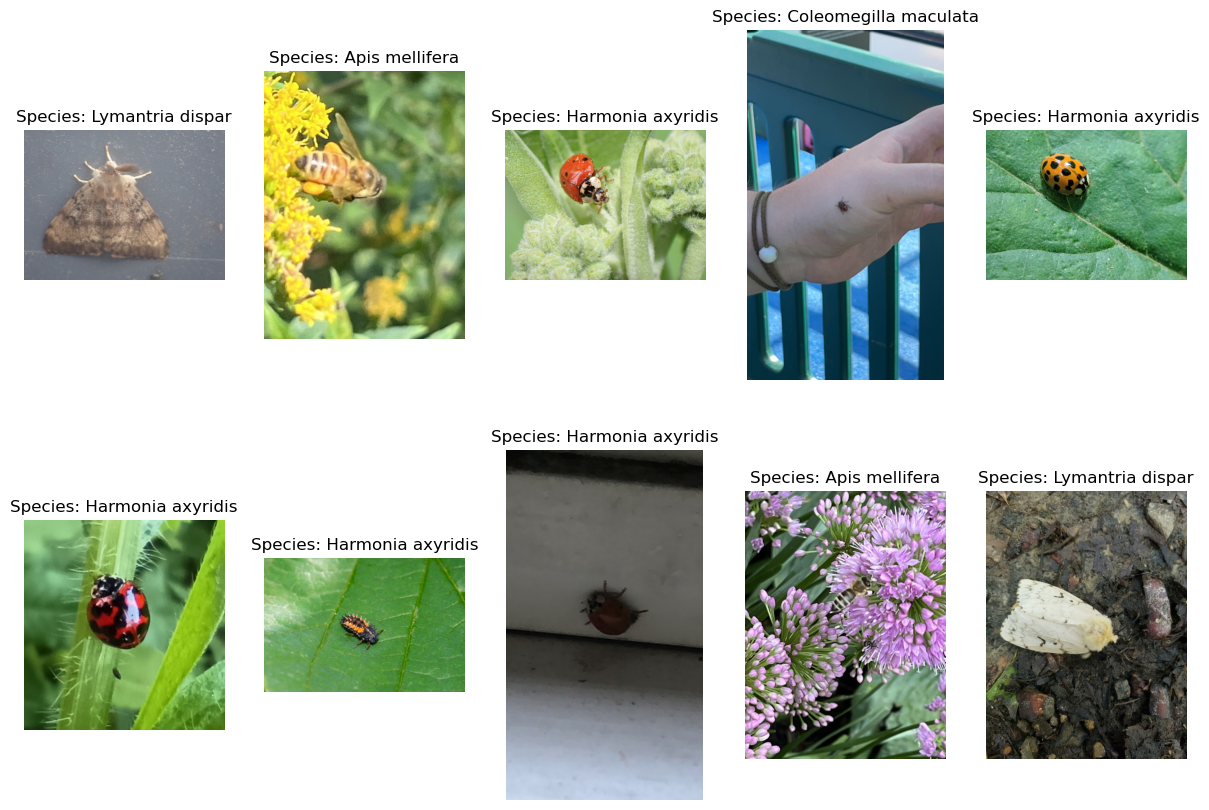

               id           species_name               common_name
114083  229292886       Lymantria dispar               Spongy Moth
122180  242347435         Apis mellifera         Western Honey Bee
39726    81654104      Harmonia axyridis         Asian Lady Beetle
132505  124023719  Coleomegilla maculata  Spotted Pink Lady Beetle
14168    31253706      Harmonia axyridis         Asian Lady Beetle
83974   164896958      Harmonia axyridis         Asian Lady Beetle
41883    83895714      Harmonia axyridis         Asian Lady Beetle
71718   129472618      Harmonia axyridis         Asian Lady Beetle
117690  234426626         Apis mellifera         Western Honey Bee
47382    88242032       Lymantria dispar               Spongy Moth
Species distribution after limiting the dataset:
species_name
Harmonia axyridis           500
Lymantria dispar            500
Jikradia olitoria           500
Vespula maculifrons         500
Chinavia hilaris            500
Cotinis nitida              500
Bombus gr

Processing Images: 100%|██████████| 9042/9042 [1:40:06<00:00,  1.51it/s]  


Baseline Performance Metrics with CustomLabelsClassifier:
  Accuracy: 88.02%
  Precision: 88.63%
  Recall: 88.02%
  F1 Score: 88.15%


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bioclip import CustomLabelsClassifier

# Paths to the invasive and native datasets
invasive_dataset_path = r'C:\aiforcon\finalproj\northeast_invasive_insects.csv'
native_dataset_path = r'C:\aiforcon\finalproj\northeast_native_insects.csv'

# Load the datasets
invasive_df = pd.read_csv(invasive_dataset_path)
native_df = pd.read_csv(native_dataset_path)

# Harmonize column names between datasets (this was before csv files were re-exported to have identical labels)
invasive_df.rename(columns={"scientific_name": "species_name"}, inplace=True)
native_df.rename(columns={"taxon_species_name": "species_name"}, inplace=True)

# Merge the datasets
combined_df = pd.concat([invasive_df, native_df], ignore_index=True)

# Define the list of species to focus on
species_list = [
    "Harmonia axyridis", "Lymantria dispar", "Agrilus planipennis",
    "Popillia japonica", "Lycorma delicatula", "Halyomorpha halys",
    "Tenodera sinensis", "Adelges tsugae", "Vespula germanica",
    "Apis mellifera", "Anoplophora glabripennis", "Graphocephala coccinea", 
    "Coleomegilla maculata", "Bombus griseocollis", "Malacosoma americanum", 
    "Cotinis nitida", "Chinavia hilaris", "Stagmomantis carolina", 
    "Vespula maculifrons", "Jikradia olitoria", "Cicindela sexguttata", "Monochamus notatus"
]

# Filter the combined dataset to include only the specified species
filtered_df = combined_df[combined_df['species_name'].isin(species_list)]

# Print dataset statistics
species_counts = filtered_df['species_name'].value_counts()
print("Species distribution across both datasets:")
print(species_counts)

total_images = len(filtered_df)
unique_species = filtered_df['species_name'].nunique()
print(f"\nTotal images: {total_images}")
print(f"Unique species: {unique_species}")

# Visualize the species distribution
species_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Species Distribution (Combined Dataset)')
plt.xlabel('Species')
plt.ylabel('Number of Images')
plt.show()

# Display sample images
sample_images = filtered_df.sample(10)
plt.figure(figsize=(15, 10))

for i, row in enumerate(sample_images.itertuples(), 1):
    response = requests.get(row.image_url)
    img = Image.open(BytesIO(response.content))
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(f"Species: {row.species_name}")
    plt.axis('off')
plt.show()

print(sample_images[['id', 'species_name', 'common_name']])

# Set a ceiling for the number of images per species
ceiling = 500
limited_metadata = pd.DataFrame()

for species in species_list:
    species_data = filtered_df[filtered_df['species_name'] == species]
    if len(species_data) > ceiling:
        species_data = species_data.sample(n=ceiling, random_state=42)
    limited_metadata = pd.concat([limited_metadata, species_data])

limited_metadata.reset_index(drop=True, inplace=True)

# Print species distribution after limiting dataset size
print("Species distribution after limiting the dataset:")
print(limited_metadata['species_name'].value_counts())

# Save temporary image path for predictions
temp_image_path = r'C:\aiforcon\finalproj\temp_image.jpg'

# Initialize the classifier
custom_classifier = CustomLabelsClassifier(species_list)

# Define performance tracking dictionary
performance = {
    "y_true": [],
    "y_pred": []
}

# Function to download and open an image from a URL
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Failed to load image from {url}: {e}")
        return None

# Process each image in the dataset
for _, row in tqdm(limited_metadata.iterrows(), total=len(limited_metadata), desc="Processing Images"):
    image_url = row['image_url']
    ground_truth = row['species_name']

    # Load image from URL
    image = load_image_from_url(image_url)
    if image is None:
        continue  # Skip if image loading failed

    image = image.convert('RGB')

    # Save image temporarily
    image.save(temp_image_path)

    # Predict using CustomLabelsClassifier
    prediction = custom_classifier.predict(temp_image_path)
    predicted_species = prediction[0]['classification'] if prediction else None

    # Store predictions and ground truths for metric calculation
    performance["y_true"].append(ground_truth)
    performance["y_pred"].append(predicted_species)

# Calculate and display performance metrics
accuracy = accuracy_score(performance["y_true"], performance["y_pred"]) * 100
precision = precision_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
recall = recall_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
f1 = f1_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100

print(f"\nBaseline Performance Metrics with CustomLabelsClassifier:\n"
      f"  Accuracy: {accuracy:.2f}%\n"
      f"  Precision: {precision:.2f}%\n"
      f"  Recall: {recall:.2f}%\n"
      f"  F1 Score: {f1:.2f}%")